<img style="float: left; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="400" height="500" /> 
    
    
### <font color='navy'> Modelos no lineales para pronósticos. 

**Nombres:** Sergio Daniel Dueñas Godinez y Kaleb Azael Avila Padilla.

**Fecha:** 6 de Febrero del 2024.

**Expediente** : 739300 y .
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/SergioDuenass/Tarea2_SDUENAS_KAVILA 

# Tarea 2: Clase 4

## Enunciado de tarea
> # <span style="color:red"> Tarea 2. </span>

Para ejemplo estudiado en esta clase data WWWUsage.csv probar lo siguiente:
1. Encontrar el mejor modelo ARIMA usando los criterios de AIC, BIC y log-verosimilud, justificando la estructura propuesta.
2. Analizar el efecto de normalizar la serie de tiempo, es decir usar MinMaxScaler para normalizar los datos. Posterior a esto, realizar el mismo precedimiento realizado en clase y encontrar el mejor modelo de ARIMA. Justifique todos los análisis realizados, incluyendo los resultados de las gráficas de ACF y PAC.
3. Investigar la implementación y teoría de los modelos SARIMAX. Además de eso, generar un modelo de pronóstico usando SARIMAX, donde todo el procediemiento anteriormente descrito es implementado, para el siguiente conjunto de datos con estacionalidad:
```
air2 = requests.get('https://www.stata-press.com/data/r12/air2.dta').content
data2 = pd.read_stata(BytesIO(air2))
data2.index = pd.date_range(start=datetime(data2.time[0], 1, 1), periods=len(data2), freq='MS')
```
**Nota**: Pueden basarse en el siguiente enlace para entender el análisis a realizar 
https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/

4. Realizar una predicción de 20 unidades de tiempo en el futuro, tanto para el modelo ARIMA como SARIMA y reportar los resulados en una gráfica donde se puedan observar los datos reales y los datos predichos, cómo en la siguiente gráfica:
![Screenshot 2024-02-05 at 8.54.42 p.m..png](<attachment:Screenshot 2024-02-05 at 8.54.42 p.m..png>)
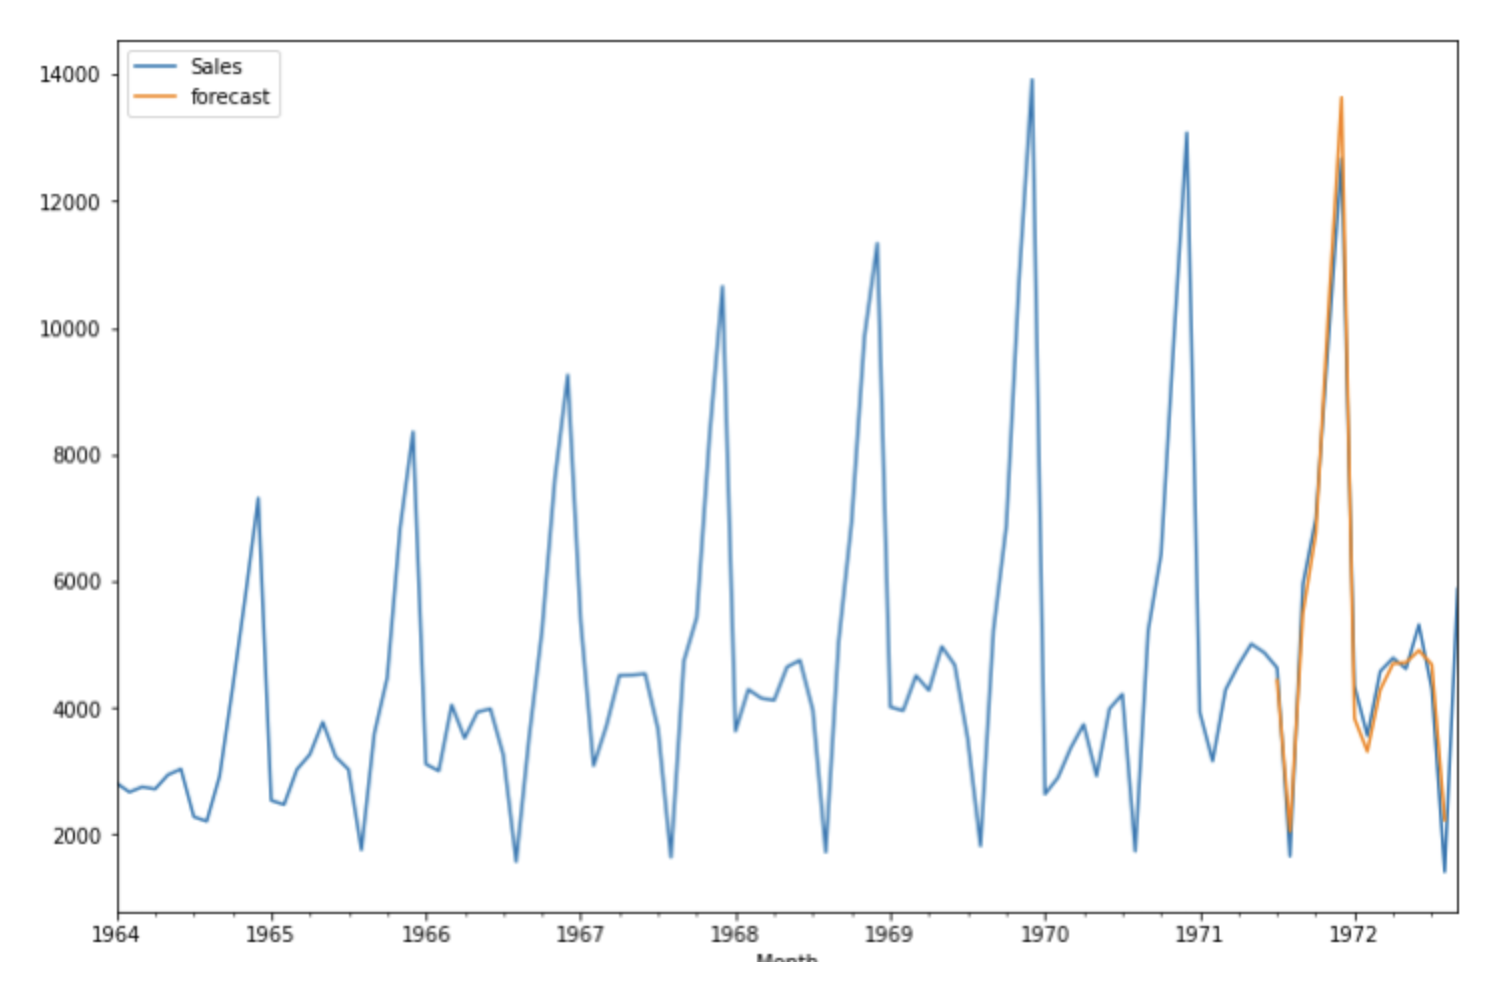

In [70]:
# Librerias a utilizar
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
import requests
from io import BytesIO
import statsmodels.api as sm
from datetime import datetime
from statsmodels.tsa.seasonal import STL

# Ignorar warnings
import warnings
warnings.filterwarnings("ignore")
# Leemos los datos
data = pd.read_csv('./dataset/WWWusage.csv', names=[ 'values'], header=0)
data.index = data.index.droplevel()

### Código de solución estudiante 1

#### Parte 1

<Axes: >

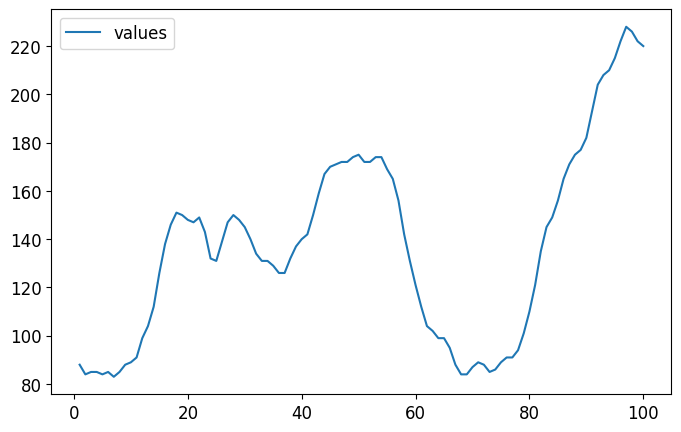

In [26]:
# Código de solución estudiante 1
# Primero quiero ver la gráfica para ver si es estacionario
data.plot(figsize=(8,5))

Veo que si tiene tendencia por lo que no es estacionaria pero verificaré con la función adf_test

In [33]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
    if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")


adf_test(data)



Results of Dickey-Fuller Test:
Test Statistic                 -2.464240
p-value                         0.124419
#Lags Used                      3.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
Non-stationary


In [34]:
# Ahora lo hacemos estacionario haciendo la primera diferenciacion

data_dif1 = data.diff().dropna()

adf_test(data_dif1)

Results of Dickey-Fuller Test:
Test Statistic                 -2.722238
p-value                         0.070268
#Lags Used                      2.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
Non-stationary


vemos que con solo una diferenciacion nos da un p-value muy cercano a nuestro valor critico del .05 por lo que decido quedarme con este

In [43]:
# Realizar el train-test split
# Realizar el train-validation-test split
train_size = int(len(data_dif1) * 0.6)  # 60% de datos para entrenamiento
val_size = int(len(data_dif1) * 0.2)    # 20% de datos para validación
test_size = len(data_dif1) - train_size - val_size

train, test = train_test_split(data_dif1, test_size=test_size, shuffle=False)
train, val = train_test_split(train, test_size=val_size, shuffle=False)


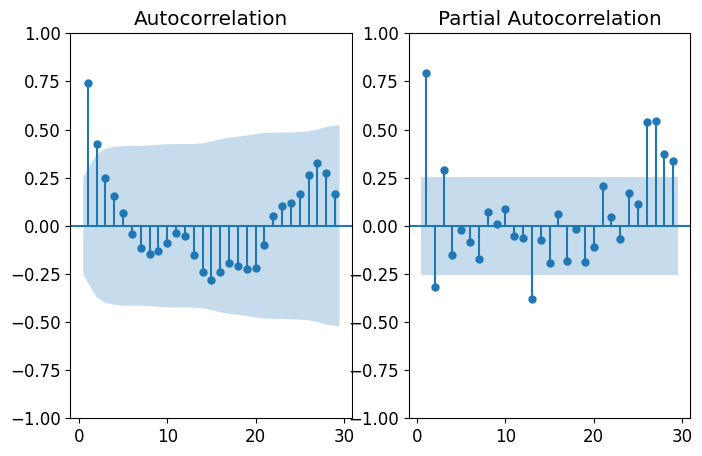

In [50]:
# Graficamos ACF y PACF
# 1. Graficar ACF y PACF
def plot_acf_pacf(s_data, kwargs=dict):
    f = plt.figure(figsize=(8,5))
    ax1 = f.add_subplot(121)
    plot_acf(s_data, zero=False, ax=ax1, **kwargs)
    ax2 = f.add_subplot(122)
    plot_pacf(s_data, zero=False, ax=ax2, method='ols', **kwargs)
    plt.show()

plot_acf_pacf(train, {'lags':29})



Viendo estas gráficas es claro que no se tiene un Moving average porque se tiene un pico muy grande y luego el comportamiento como senoidal. Y para el PACF tenemos 3 puntos en el 0, 1 y 2, por lo que el modelo quedaría ***(p=3,d=1,q=0)***

In [52]:
# Ahora creamos el modelo ARIMA
arima = ARIMA(train, order=(3, 1, 0))
model1 = arima.fit()
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                   59
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -152.984
Date:                Mon, 05 Feb 2024   AIC                            313.968
Time:                        23:33:15   BIC                            322.209
Sample:                             0   HQIC                           317.178
                                 - 59                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2476      0.148      1.676      0.094      -0.042       0.537
ar.L2         -0.4232      0.114     -3.696      0.000      -0.648      -0.199
ar.L3          0.0442      0.155      0.285      0.7

Vemos que mejoramos la log verosimilitud al de la clase, ya que teníamos -256.198 y  -248.872 y en este tenemos un -152.984, y para este valor se busca maxearlo por lo que queda mejor y en cuanto al AIC y BIC, en la clase tuvimos para AIC 513.744 y 518.396, y en el nuestro tenemos 313.968, recordando que se busca disminuir estos valores. Para BIC en la clase tuvimos;  526.151,  534.505 y nosotros obtuvimos 322.209. Como se muestra en la siguiente tabla.

| |Log-Verosimilitud | AIC | BIC |
|---|---|---|---|
| model | -152.984 | 313.968 | 322.209 |
| Clase1 | -248.872 | 513.744 | 534.505 |
| Clase2 | -256.198 | 518.396 | 526.151 |

#### Parte 2

In [54]:
# Normalizamos los datos con el MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(data))

In [55]:
# Verificamos si es estacionario
adf_test(scaled)

Results of Dickey-Fuller Test:
Test Statistic                 -2.464240
p-value                         0.124419
#Lags Used                      3.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
Non-stationary


Vemos que no lo es por lo que diferenciamos

In [56]:
scaled_dif1 = scaled.diff().dropna()
# Realizamos el test de ADF
adf_test(scaled_dif1)

Results of Dickey-Fuller Test:
Test Statistic                 -2.722238
p-value                         0.070268
#Lags Used                      2.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
Non-stationary


Podemos analizar que es casi igual a antes de normalizarlos y nos dió buenos resultados. por lo que otra vez usaré lo mismo

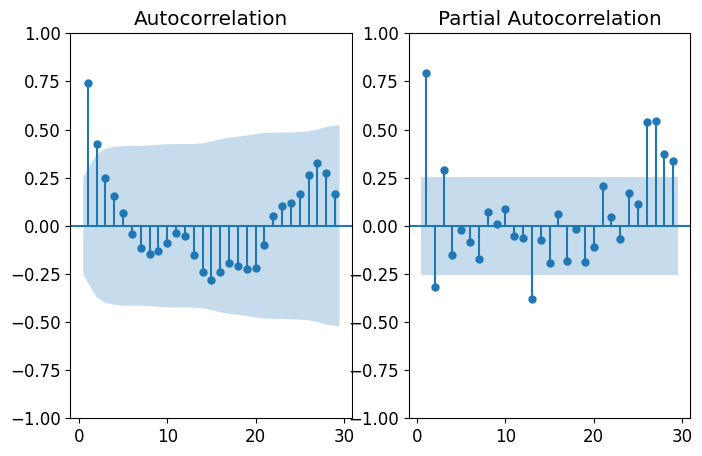

In [57]:
# Dividimos en train, test y validation
train_scaled, test_scaled = train_test_split(scaled_dif1, test_size=test_size, shuffle=False)
train_scaled, val_scaled = train_test_split(train_scaled, test_size=val_size, shuffle=False)

# Vemos las funciones de ACF y PACF
plot_acf_pacf(train_scaled, {'lags':29})

De igual forma me quedaría con (p=3,d=1,q=0)

In [61]:
# Ahora creamos el modelo ARIMA
arima2 = ARIMA(train_scaled, order=(3, 1, 0))
model2 = arima2.fit()
print(model2.summary())

                               SARIMAX Results                                
Dep. Variable:                      0   No. Observations:                   59
Model:                 ARIMA(3, 1, 0)   Log Likelihood                 135.667
Date:                Tue, 06 Feb 2024   AIC                           -263.333
Time:                        00:06:44   BIC                           -255.092
Sample:                             0   HQIC                          -260.123
                                 - 59                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2474      0.148      1.675      0.094      -0.042       0.537
ar.L2         -0.4233      0.114     -3.698      0.000      -0.648      -0.199
ar.L3          0.0437      0.155      0.282      0.7

Vemos que mejora mucho en comparación con antes de normalizar

| |Log-Verosimilitud | AIC | BIC |
|---|---|---|---|
| model 1 | -152.984 | 313.968 | 322.209 |
| model 2 | 135.667 | -263.333 | -255.092 |

<Axes: >

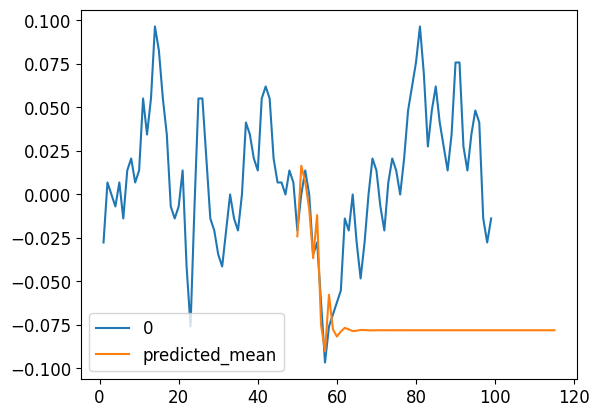

In [68]:
y_h = model2.predict(start=50, end=115).to_frame()
ax = scaled_dif1.plot()
y_h.plot(ax=ax)

#### Parte 3

In [81]:
# Download the data
air2 = requests.get('https://www.stata-press.com/data/r12/air2.dta').content
data2 = pd.read_stata(BytesIO(air2))

data2['time'] = data2['time'].astype(int)
data2.index = pd.date_range(start=datetime(data2['time'][0], 1, 1), periods=len(data2), freq='MS')


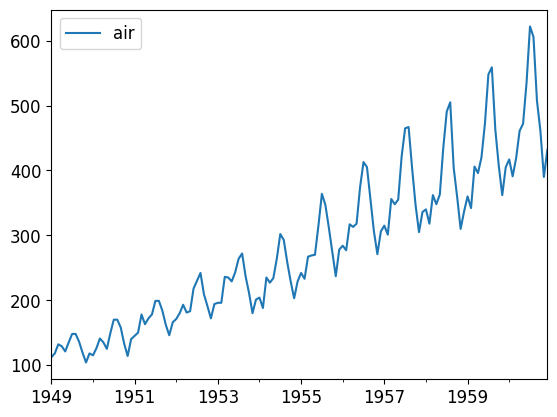

In [82]:
data2 = data2[["air"]]
data2.plot()
plt.show()

Investigando sobre SARIMAX, vi que funciona con series de tiempo con estacionalidad como la que tenemos aquí además de tomar en cuenta variables independientes y ahora además de tomar p,d y q, también pide 𝑚 el cuál, indica al número de períodos en cada temporada.

Test estacionariedad serie original
-------------------------------------
ADF Statistic: 0.8153688792060527, p-value: 0.991880243437641

Test estacionariedad para serie diferenciada (order=1)
--------------------------------------------------
ADF Statistic: -2.8292668241699865, p-value: 0.054213290283827265

Test estacionariedad para serie diferenciada (order=2)
--------------------------------------------------
ADF Statistic: -16.384231542468473, p-value: 2.732891850014397e-29


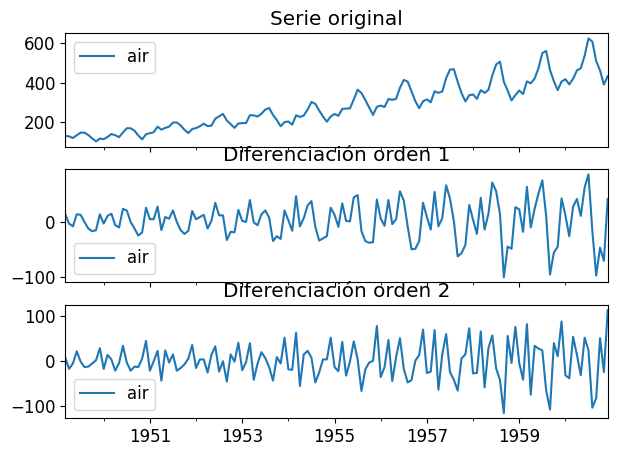

In [87]:
# Test estacionariedad
from statsmodels.tsa.stattools import kpss
data2_diff = data2.diff().dropna()
data2_diff2 = data2.diff().diff().dropna()

print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(data2)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(data2_diff)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(data2_diff2)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')

# Gráfico series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
data2.plot(ax=axs[0], title='Serie original')
data2_diff.plot(ax=axs[1], title='Diferenciación orden 1')
data2_diff2.plot(ax=axs[2], title='Diferenciación orden 2');

# Referencia de: https://cienciadedatos.net/documentos/py51-modelos-arima-sarimax-python

Vemos con solo la primera diferenciación ya queda casi perfecto por lo que me quedaré con esa

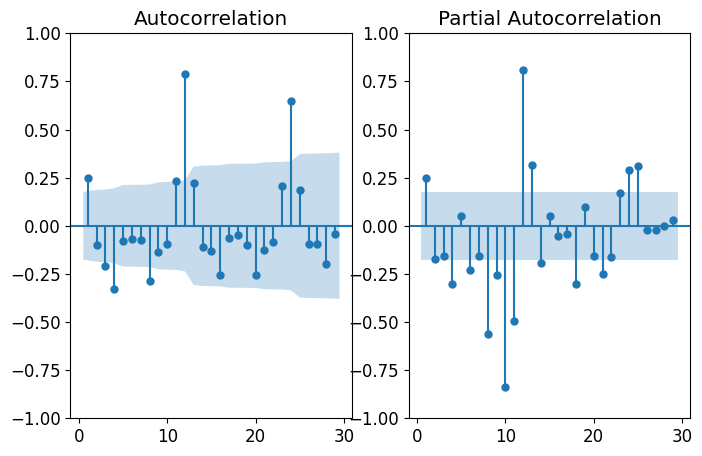

In [88]:
# Dividimos en train, test y validation
train_2, test_2 = train_test_split(data2_diff, test_size=test_size, shuffle=False)
train_2, val_2 = train_test_split(data2_diff, test_size=val_size, shuffle=False)

# Vemos las funciones de ACF y PACF
plot_acf_pacf(train_2, {'lags':29})

Utilizaría p = 1 por el pico en el 1 y en lag 12 de q lo mismo pues tiene un comportamiento similar y la d = 1 ya que solo lleva una diferencial y para la season usé 12 ya que los datos son mensuales por lo que el orden quedaría ***(1,1,1)(1,1,1,12)***

In [96]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarimax_ = SARIMAX(endog = train_2, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12))
model_sarimax = sarimax_.fit(disp=0)
model_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                air   No. Observations:                  124
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -418.448
Date:                            Tue, 06 Feb 2024   AIC                            846.896
Time:                                    01:12:11   BIC                            860.443
Sample:                                02-01-1949   HQIC                           852.392
                                     - 05-01-1959                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2301      0.097     -2.377      0.017      -0.420      -0.040
ma.L1         -0.9999      5.540     -0.180      0.857     -11.857       9.857
ar.S.L12      -0.9997      0.256     -3.912      0.000      -1.501      -0.499
ma.S.L12       0.9925      3.363      0.295      0.768      -5.598       7.583
sigma2        98.6410    616.866      0.160      0.873   -1110.395    1307.677
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.24
Prob(Q):                              0.93   Prob(JB):                         0.89
Heteroskedasticity (H):               1.49   Skew:                             0.02
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

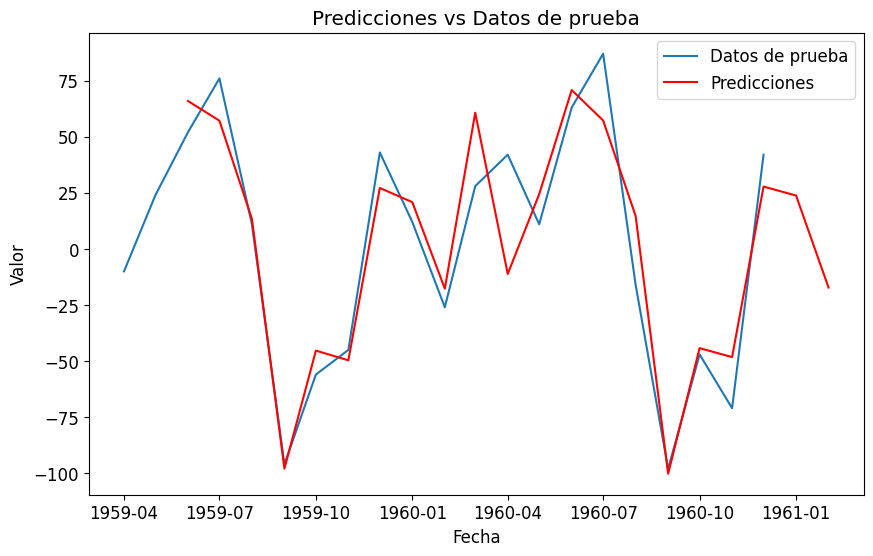

In [100]:
predicciones_statsmodels = model_sarimax.get_forecast(steps=len(test_2)).predicted_mean
predicciones_statsmodels.name = 'predicciones_statsmodels'

plt.figure(figsize=(10, 6))

# Plot de datos de prueba
plt.plot(test_2, label='Datos de prueba')

# Plot de predicciones
plt.plot(predicciones_statsmodels.index, predicciones_statsmodels, color='red', label='Predicciones')

plt.title('Predicciones vs Datos de prueba')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

#### Parte 4

/var/folders/vj/xp36g_9s7lj2v05vvcsms4500000gn/T/ipykernel_71139/3363462707.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_future = pd.date_range(data2.index[-1] + pd.DateOffset(months=1), periods=future_steps, freq='M')


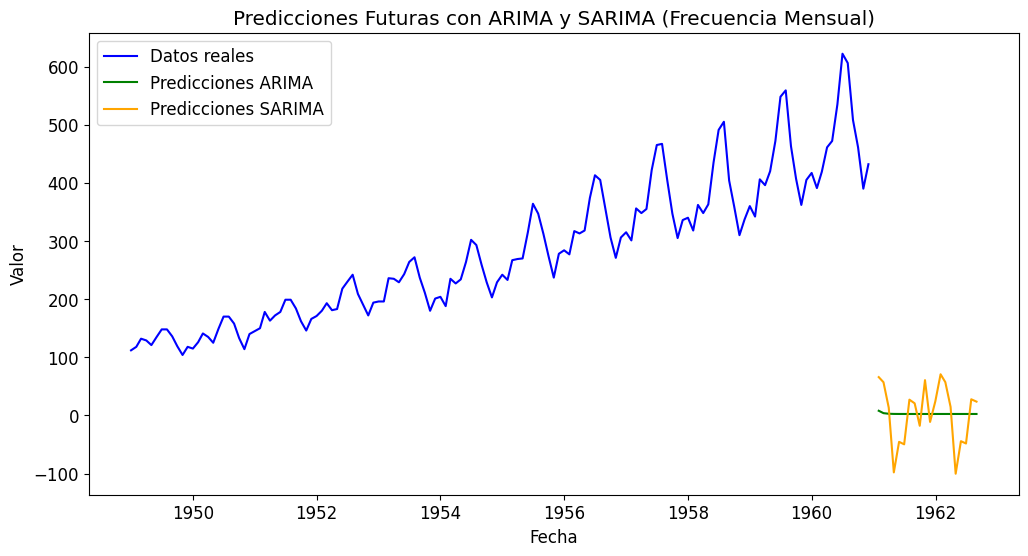

In [103]:
# Entrenar modelo ARIMA
order_arima = (1, 1, 1)  # Reemplaza con los órdenes adecuados
model_arima = ARIMA(train_2, order=order_arima)
results_arima = model_arima.fit()

# Predecir 20 unidades de tiempo en el futuro (meses)
future_steps = 20
index_future = pd.date_range(data2.index[-1] + pd.DateOffset(months=1), periods=future_steps, freq='M')

# Predicciones ARIMA
forecast_arima = results_arima.get_forecast(steps=future_steps).predicted_mean

# Predicciones SARIMA
forecast_sarima = model_sarimax.get_forecast(steps=future_steps).predicted_mean

# Visualización de resultados
plt.figure(figsize=(12, 6))
plt.plot(data2.index, data2['air'], label='Datos reales', color='blue')
plt.plot(index_future, forecast_arima, label='Predicciones ARIMA', color='green')
plt.plot(index_future, forecast_sarima, label='Predicciones SARIMA', color='orange')

plt.title('Predicciones Futuras con ARIMA y SARIMA (Frecuencia Mensual)')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

Código de solución estudiante 2

In [ ]:
# Código de solución estudiante 2
.
.
.
.
